In [32]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms, utils
from torch.utils import data

import matplotlib.pyplot as plt
import numpy as np

### 이미지를 텐서로 바꿔주는 코드

In [8]:
transform = transforms.Compose([
    transforms.ToTensor()
])

### Fashion mnist

In [9]:
trainset = datasets.FashionMNIST(
    root      = './.data/', 
    train     = True,
    download  = True,
    transform = transform
)
testset = datasets.FashionMNIST(
    root      = './.data/', 
    train     = False,
    download  = True,
    transform = transform
)

100.0%

Extracting ./.data/FashionMNIST\raw\train-images-idx3-ubyte.gz


111.0%

Extracting ./.data/FashionMNIST\raw\train-labels-idx1-ubyte.gz


100.0%

Extracting ./.data/FashionMNIST\raw\t10k-images-idx3-ubyte.gz


159.1%

Extracting ./.data/FashionMNIST\raw\t10k-labels-idx1-ubyte.gz
Processing...
Done!


In [33]:
batch_size = 64

train_loader = data.DataLoader(dataset=trainset, batch_size=batch_size, shuffle=True)
test_loader = data.DataLoader(dataset= testset, batch_size=batch_size, shuffle=True)

In [34]:
dataiter = iter(train_loader)
images, labels = next(dataiter)

### 데이터 살펴보기 : 여러개

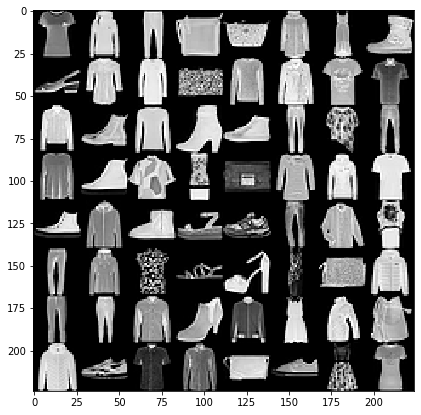

tensor([0, 2, 1, 8, 8, 4, 3, 9, 5, 6, 2, 8, 2, 4, 0, 6, 4, 9, 2, 9, 7, 1, 6, 1,
        2, 7, 6, 0, 8, 0, 2, 0, 7, 4, 9, 5, 7, 1, 6, 3, 1, 4, 6, 5, 5, 3, 8, 4,
        1, 1, 6, 9, 4, 3, 4, 8, 4, 7, 6, 6, 8, 7, 3, 0])


In [35]:
img   = utils.make_grid(images, padding=0)
npimg = img.numpy()
plt.figure(figsize=(10, 7))
plt.imshow(np.transpose(npimg, (1,2,0)))
plt.show()
print(labels)


In [36]:

CLASSES = {
    0: 'T-shirt/top',
    1: 'Trouser',
    2: 'Pullover',
    3: 'Dress',
    4: 'Coat',
    5: 'Sandal',
    6: 'Shirt',
    7: 'Sneaker',
    8: 'Bag',
    9: 'Ankle boot'
}


In [37]:
for label in labels:
    index = label.item()
    print(CLASSES[index])

T-shirt/top
Pullover
Trouser
Bag
Bag
Coat
Dress
Ankle boot
Sandal
Shirt
Pullover
Bag
Pullover
Coat
T-shirt/top
Shirt
Coat
Ankle boot
Pullover
Ankle boot
Sneaker
Trouser
Shirt
Trouser
Pullover
Sneaker
Shirt
T-shirt/top
Bag
T-shirt/top
Pullover
T-shirt/top
Sneaker
Coat
Ankle boot
Sandal
Sneaker
Trouser
Shirt
Dress
Trouser
Coat
Shirt
Sandal
Sandal
Dress
Bag
Coat
Trouser
Trouser
Shirt
Ankle boot
Coat
Dress
Coat
Bag
Coat
Sneaker
Shirt
Shirt
Bag
Sneaker
Dress
T-shirt/top


### 데이터 살펴보기 : 하나씩

(28, 28)


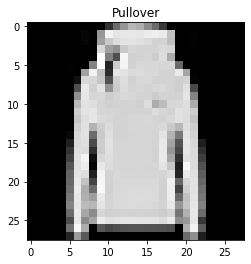

In [38]:
idx = 1

item_img = images[idx]
item_npimg = item_img.squeeze().numpy()
plt.title(CLASSES[labels[idx].item()])
print(item_npimg.shape)
plt.imshow(item_npimg, cmap='gray')
plt.show()

## 신경망

### 사용장치 선택

In [40]:
USE_CUDA = torch.cuda.is_available()
DEVICE = torch.device("cuda" if USE_CUDA else "cpu")

## 뉴럴넷 구성

In [44]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128,10)
        
    def forward(self, x):
        x = x.view(-1,784)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

### 모델 준비

In [46]:
model = Net().to(DEVICE) # 모델의 파라미터를 CPU나 GPU로 보냄
optimizer = optim.SGD(model.parameters(), lr=0.01)

## 학습

In [47]:
def train(model, train_loader, optimizer):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        # 학습 데이터를 DEVICE의 메모리로 보냄
        data, target = data.to(DEVICE), target.to(DEVICE)
        optimizer.zero_grad()
        output = model(data)
        loss = F.cross_entropy(output, target)
        loss.backward()
        optimizer.step()

### 테스트

In [48]:
def evaluate(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(DEVICE), target.to(DEVICE)
            output = model(data)

            # 모든 오차 더하기
            test_loss += F.cross_entropy(output, target,
                                         reduction='sum').item()
            
            # 가장 큰 값을 가진 클래스가 모델의 예측입니다.
            # 예측과 정답을 비교하여 일치할 경우 correct에 1을 더합니다.
            pred = output.max(1, keepdim=True)[1]
            correct += pred.eq(target.view_as(pred)).sum().item()
            
    test_loss /= len(test_loader.dataset)
    test_accuracy = 100. * correct / len(test_loader.dataset)
    return test_loss, test_accuracy

In [49]:
for epoch in range(1, EPOCHS + 1):
    train(model, train_loader, optimizer)
    test_loss, test_accuracy = evaluate(model, test_loader)
    
    print('[{}] Test Loss: {:.4f}, Accuracy: {:.2f}%'.format(
          epoch, test_loss, test_accuracy))

[1] Test Loss: 0.8334, Accuracy: 67.97%
[2] Test Loss: 0.6895, Accuracy: 73.51%
[3] Test Loss: 0.5741, Accuracy: 79.87%
[4] Test Loss: 0.5364, Accuracy: 80.97%
[5] Test Loss: 0.5156, Accuracy: 81.69%
[6] Test Loss: 0.4920, Accuracy: 82.45%
[7] Test Loss: 0.5133, Accuracy: 81.38%
[8] Test Loss: 0.4675, Accuracy: 83.17%
[9] Test Loss: 0.4689, Accuracy: 83.39%
[10] Test Loss: 0.4578, Accuracy: 83.59%
[11] Test Loss: 0.5155, Accuracy: 80.37%
[12] Test Loss: 0.4394, Accuracy: 84.50%
[13] Test Loss: 0.4390, Accuracy: 84.22%
[14] Test Loss: 0.4267, Accuracy: 84.84%
[15] Test Loss: 0.4345, Accuracy: 84.75%
[16] Test Loss: 0.4229, Accuracy: 85.04%
[17] Test Loss: 0.4216, Accuracy: 85.02%
[18] Test Loss: 0.4091, Accuracy: 85.55%
[19] Test Loss: 0.4105, Accuracy: 85.19%
[20] Test Loss: 0.3996, Accuracy: 85.73%
[21] Test Loss: 0.3980, Accuracy: 85.77%
[22] Test Loss: 0.4023, Accuracy: 85.73%
[23] Test Loss: 0.3937, Accuracy: 85.93%


KeyboardInterrupt: 

In [53]:
torch.cuda.get_device_name(0)

AssertionError: Torch not compiled with CUDA enabled